# Image Compression and Recovery
Lixun Zhang  
September 14, 2016

# 1 Introduction

The purpose of this notebook is to demonstrate how to compress and recover image data. Dimension reduction techniques will be used in this notebook. At the end of the notebook we'll also look at how to compress new images based on the training data. Advantages of dimension reduction include:
  * data compression: reduce the storage requirements and speed up learning algorithm
  * data visualization: lower dimension data are easier to visualize than higher dimension ones

## 2 Data
### 2.1 Data Source
The dataset used in his example is from [MSRA-CFW][data link]. Ten pictures from the [smaller set][subset link] of 10 people were used in the analysis and they are saved in an Azure Blob storage. More information about Azure Blob storage can be found [here][blob link].  

[data link]: http://research.microsoft.com/en-us/projects/msra-cfw/
[subset link]: https://onedrive.live.com/?cid=1E04F731C1DD71BC&id=1E04F731C1DD71BC%21113
[blob link]: https://azure.microsoft.com/en-us/documentation/articles/storage-introduction/

### 2.2 Prepare Data

If you want to use your own set of images, you can save them in a local directory and use the following lines of code  to upload your data to an Azure Blob storage. 

Run the following block only if you are using your own images and want to upload them to your own Azure Blob storage acount. To remove the comments, you can select all the code and then press CTRL + / in Windows.

In [1]:
# import os # to work with directories
# from azure.storage.blob import BlobService # to work with Azure blob storage

# mydir = ""       # Enter your local image directory if using your own images
# myaccount = ""   # Enter your Azure storage account if using your own data
# mykey = ""       # Enter your own Azure storage key if using your own data
# mycontainer = "" # Enter the name of the container you want to create 

# # establish link to Azure blob storage
# blob_service = BlobService(account_name= myaccount, account_key = mykey)

# # create a container
# blob_service.create_container(container_name = mycontainer)

# # Uplod all images from a local folder to a container
# for dirname, dirnames, filenames in os.walk(mydir):
#     for filename in filenames:
#         # print path to all filenames.
#         print(os.path.join(dirname, filename))
#         # upload an image
#         blob_service.put_block_blob_from_path(
#             mycontainer,
#             filename,
#             os.path.join(dirname, filename),
#             x_ms_blob_content_type='image/png'
#         )    

### 2.3 Download and Prepare Data

Fill in the information about your blob storage below.

In [2]:
myaccount = "tobedeleted"    # Azure blob storage account name
mykey = None        # Azure blob storage key
mycontainer = "images"  # Container name

After connecting with the Azure blob storage, we can save the files names in a list using the following code.

In [3]:
import os # to work with directories
from azure.storage.blob import BlobService # to work with Azure blob storage

# establish link to Azure blob storage
blob_service = BlobService(account_name= myaccount, account_key = mykey)

# list all files in a blob storage
blobs = []
marker = None
while True:
    batch = blob_service.list_blobs(container_name = mycontainer, 
                                    marker=marker)
    blobs.extend(batch)
    if not batch.next_marker:
        break
    marker = batch.next_marker

Then we download and prepare the image data as below.

In [4]:
import numpy as np # matrix multiplication and array
from PIL import Image # to open images

# get the current directory
downloaddir = os.getcwd()

# set image shape
image_shape = (64, 64)

# to save images
mylist = []

# save image data into list
for blob in blobs:
    # download the contents of the blob to local
    blob_service.get_blob_to_path(container_name = mycontainer, 
                                  blob_name = blob.name, 
                                  file_path = blob.name)
    img = Image.open(os.path.join(downloaddir, blob.name)) # open
    img3 = img.convert('L') # convert to 8-bit pixesls, black and white
    img4 = img3.resize(image_shape) # resize image
    arr = np.array(img4) # convert to array
    arr_list = arr.reshape(1, -1)[0] # save as 1 * 4096 dimentional list
    mylist.append(arr_list)  # add data to list     
    # delete the downloaded file from local
    os.remove(os.path.join(downloaddir, blob.name))

# create an array
myarray = np.array(mylist)
n_samples, n_features = myarray.shape

# global centering
myarray_centered = myarray - myarray.mean(axis=0)

# local centering
myarray_centered -= myarray_centered.mean(axis=1).reshape(n_samples, -1)

## 3 Image decomposition

The following function will be used to plot images.

In [5]:
import matplotlib.pyplot as plt # for plotting

# inline plotting
%matplotlib inline

# function for plotting image
def plot_images(title, images, n_row=2, n_col=3):
    plt.figure(figsize=(2.2 * n_col, 2.2 * n_row))
    plt.suptitle(title, fontsize=16)
    for j, img in enumerate(images):
        plt.subplot(n_row, n_col, j + 1)
        plt.imshow(img.reshape(image_shape), cmap=plt.cm.gray)
        plt.xticks(())
        plt.yticks(())
    plt.subplots_adjust(left = 0.05, bottom = 0.02, right = 0.95, top = 0.92, 
                        wspace = 0.02, hspace = 0.02)    

The [scikit-learn][sklearn link] package has several decomposition methods and we'll use MiniBatchSparsePCA here.
[sklearn link]: http://scikit-learn.org/stable/

In [6]:
from sklearn import decomposition
from numpy.random import RandomState # random numbers

# specify number of components
n_row, n_col = 2, 3
n_components = n_row * n_col

# specify decomposition methods
rng = RandomState(0)
name = 'Sparse compomponents - MiniBatchSparsePCA'
estimator = decomposition.MiniBatchSparsePCA(n_components=n_components, 
                                      alpha=0.8,
                                      n_iter=100, batch_size=3,
                                      random_state=rng)
# specify data
data = myarray_centered

The selected number of components are extracted and printed using the following code.

Extracting the top 6 Sparse compomponents - MiniBatchSparsePCA
done in 3.2s


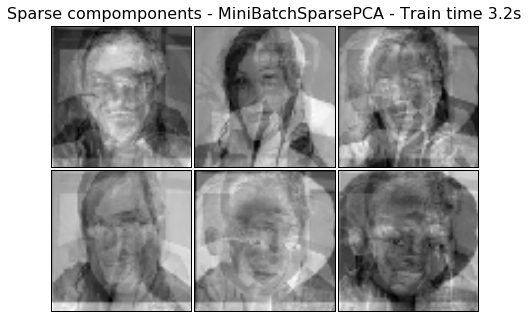

In [7]:
from time import time # to record running time

# extract components 
print("Extracting the top {0:d} {1:s}".format(n_components, name))
t0 = time()
W = estimator.fit_transform(data)
H = estimator.components_
train_time = (time() - t0)
print("done in {0:0.1f}s".format(train_time))

# plot the components
plot_images('{0:s} - Train time {1:0.1f}s'.format(name, train_time),
             H[:n_components], n_row=n_row, n_col=n_col)

## 4 Image Recovery
We can use the saved components to recover images. The following code compares the original pictures with the recovered ones for 6 samples.

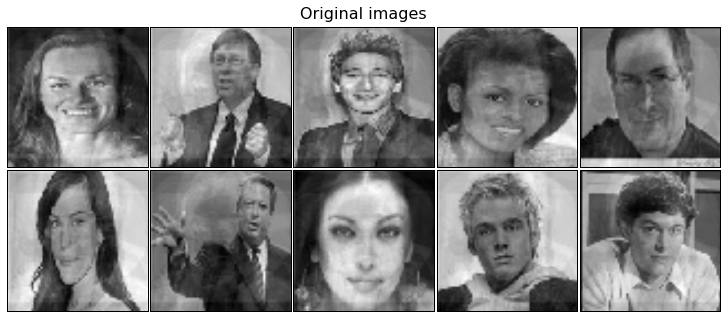

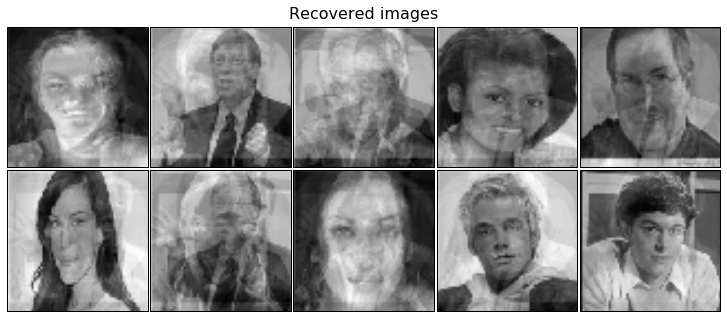

In [8]:
# recover images
V_approx = np.dot(W, H)

# plot the original and recovered images
n_row_person = 2
n_col_person = 5
n_person = n_row_person * n_col_person
plot_images("Original images", data[:n_person], n_row = n_row_person,
            n_col = n_col_person)
plot_images("Recovered images", V_approx[:n_person], n_row = n_row_person,
            n_col = n_col_person)
            

## 5 Discussion
To further illustrate how dimension reduction helps data compression, consider the following example. Suppose we have 10,000 pictures, each having 4,096 pixel values. Storing the original data would need 40,960,000 data points. If we extracted the top 100 components, we would store 409,600 (=100 \* 4,096) values for these components and need 1,000,000 (=10,000 \* 100) for the pictures. So with dimension reduction we now just need 1,409,600 data points. This means a reduction of approximately 97% in storage space.

If there are new data points, we can use the following code to extract the W matrix. This can be useful when, for example, the components are used in supervised machine learning as predictors and we want to make predictions for new data points.

In [9]:
# specify new data using origianl data
data_new = data

# calculate the W matrix for new data
W_new = estimator.transform(data_new)

---  
Created by a Microsoft Employee.  
Copyright (c) Microsoft. All Rights Reserved.